In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
#!python
from numpy import *
from numpy.random import *
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
import pyparticleest.utils.kalman as kalman

import numpy as np
import scipy as sp
import scipy.special
import scipy.linalg

# Exact Result by Kalman Filter

In [3]:
def KalFilt(y,sigma2v,sigma2e,xbar0,sigma20):
    
    # signal length
    K = y.shape[0]
    
    #filter data structures
    xprior = zeros(K,dtype=float) # one-step prediction: xprior[k] = x_{k|k-1}
    s2prior = zeros(K,dtype=float) # \sigma^2_{k|k-1}
    
    xpost = zeros(K,dtype=float) # posterior at time k: xpost[k] = x_{k|k}
    s2post = zeros(K,dtype=float) # \sigma^2_{k|k}

    for k in range(K):
        
        if k == 1:
            xprior[k] = xbar0
            s2prior[k] = sigma20 + sigma2e
        else:
            xprior[k] = xpost[k-1]
            s2prior[k] = s2post[k-1] + sigma2e
        
        ck = s2prior[k]/(sigma2v + s2prior[k])
        
        xpost[k] = xprior[k] + ck*(y[k]-xprior[k])
        
        s2post[k] = 1.0/(1.0/sigma2v + 1.0/s2prior[k])
        
    v = (sigma2v + s2prior)
    #llhd = sum(log(normpdf(y,xprior, v**0.5 )))
    llhd = -K/2. * np.log(2*np.pi) - .5*np.sum(np.log(v)) - .5 * np.sum((y - xprior)**2 / v)

    return (xpost,s2post,llhd,)
    return (xpost,s2post)
    return llhd

In [79]:
mat = np.loadtxt('train_data.txt')
Y = mat[19,1:]
T = len(Y)

In [5]:
sigma2v = 5.0

In [63]:
sigma2e = np.arange(0.01, 0.51, 0.01)
print sigma2e

[ 0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12
  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24
  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35  0.36
  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48
  0.49  0.5 ]


In [80]:
loglikelihood = np.empty(len(sigma2e))
for i in range(len(sigma2e)): 
    sigma = sigma2e[i]
    [xpost, s2post, llhdKal] = KalFilt(Y, sigma2v, sigma, 0.0, sigma)
    loglikelihood[i] = llhdKal

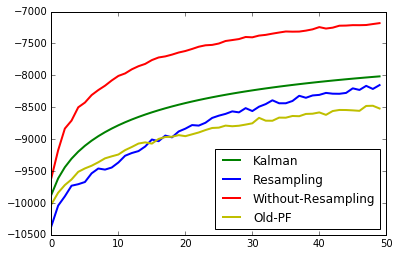

In [92]:
plt.plot(loglikelihood,'g-',linewidth=2.0, label='Kalman')
plt.plot(loglikelihood_withresampling,'b-',linewidth=2.0, label='Resampling')
plt.plot(loglikelihood_withoutresampling,'r-',linewidth=2.0, label='Without-Resampling')
plt.plot(loglikelihood_oldpf,'y-',linewidth=2.0, label='Old-PF')
plt.legend(loc='best')

# PF with Resampling

In [11]:
def resample(weights):
  n = len(weights)
  indices = []
  C = [0.] + [sum(weights[:i+1]) for i in range(n)]
  u0, j = random(), 0
  for u in [(u0+i)/n for i in range(n)]:
    while u > C[j]:
      j+=1
    indices.append(j-1)
  return indices

In [12]:
def gaussian(X, Q):
    #log-pdf of p(x_t|x_{t-1})
    return -0.5 * (l2pi + np.log(Q) + (X ** 2) / Q)

In [13]:
def Do_Kalman_Likelihood(y, sigma2obs, sigma2e):
    """MAP solution, inverse covariance matrix, and marginal loglikelihood of state-space model

    :param y: Observations (K,)
    :param sigma2obs: Variance of observation noise (can be scalar or vector)
    :param sigma2e: Variance of process noise
    :return: x_map, L, marginal_loglikelihood, joint_loglikelihood
    """
    # Build diagonals of information matrix
    sigma2obs *= np.ones(len(y))
    D = 1. / sigma2obs + 2. / sigma2e
    D[-1] = 1. / sigma2obs[-1] + 1. / sigma2e
    B = -np.ones(len(D)) / sigma2e
    B[0] = 0.
    
    # Solve, assuming x_init=0 for simplicity
    #L = sp.linalg.cholesky_banded((D, B), lower=True)
    U = sp.linalg.cholesky_banded((B, D), lower=False)

    x_map = sp.linalg.cho_solve_banded([U, False], y / sigma2obs)

    # Compute joint and marginal probabilities
    joint_loglikelihood = -.5 * ((np.sum(np.diff(x_map)**2) + x_map[0]**2) / sigma2e +
                                 np.sum((y - x_map)**2 / sigma2obs) +
                                 (len(y) * np.log(2*np.pi*sigma2e * 2*np.pi) + np.sum(np.log(sigma2obs))))
    marginal_loglikelihood = len(y)/2. * np.log(2*np.pi) + joint_loglikelihood - np.sum(np.log(U[-1]))
    return x_map, U, marginal_loglikelihood, joint_loglikelihood

In [14]:
# Forward particles
N = 1000
#
l2pi = math.log(2 * math.pi)


In [15]:
loglikelihood_withresampling = np.empty(len(sigma2e))

In [16]:
def filtering(Y, Q, mode, variance):
    samples = np.random.normal(0,1,[T+1,N])
    w = np.empty([T,N])
    W = np.empty([T,N])
    X = np.reshape (np.repeat(mode,N),[T+1,N]) + samples * np.reshape (np.repeat(np.sqrt(variance),N),[T+1,N])
    ancestor = np.empty([T+1,N])
    ancestor[0,:] = X[0,:]
    for t in range(T):
        w[t,:] = gaussian(Y[t]-X[t+1,:], sigma2v) + gaussian(X[t+1,:]-ancestor[t,:], Q) - gaussian(X[t+1,:]-mode[t+1], variance[t+1])
        W[t,:] = np.exp(w[t,:] - np.max(w[t,:])) 
        W[t,:] = W[t,:]/ np.sum(W[t,:])
        ancestor[t+1,:]= X[t+1,resample(W[t,:])]
        
    return X, w, W, ancestor

In [18]:
for i in range(len(sigma2e)):
    Q = sigma2e[i]
    [x_map, U, marginal_loglikelihood, joint_loglikelihood] = Do_Kalman_Likelihood(Y, sigma2v, Q) 
    mode = np.empty(T+1)
    variance = np.empty(T+1)
    mode[0] = 0
    variance[0] = Q
    for t in range(T):
        mode[t+1] = x_map[t]
        variance[t+1] = U[1][t]
        
    [X, w, W, ancestor] = filtering(Y, Q, mode, variance)
    maxlogweight = np.max(w, axis=1)
    weight = np.exp(w - np.reshape(np.repeat(maxlogweight, N),(T, N)))
    loglikelihood_withresampling[i] = np.sum(np.log(np.sum(weight, axis = 1)/N))+np.sum(maxlogweight)

# PF without Resampling

In [56]:
def filtering_withoutresampling(Y, Q, mode, variance):
    samples = np.random.normal(0,1,[T+1,N])
    X = np.reshape (np.repeat(mode,N),[T+1,N]) + samples * np.reshape (np.repeat(np.sqrt(variance),N),[T+1,N])
    #X = np.reshape (np.repeat(mode,N),[T+1,N]) + samples * np.reshape (np.repeat(np.sqrt(variance + Q),N),[T+1,N])
    w = gaussian(np.reshape(np.repeat(Y,N),[T,N])-X[1:], sigma2v) + gaussian(np.diff(X, axis = 0), Q) - gaussian(X[1:]-np.reshape (np.repeat(mode[1:], N) ,[T,N]), np.reshape (np.repeat(variance[1:], N) ,[T,N]))
    W = np.exp(w - np.reshape(np.repeat(np.max(w, axis =1), N), [T,N])) 
    W = W/ np.reshape(np.repeat(np.sum(W, axis =1), N), [T,N])
    return X, w, W

In [86]:
loglikelihood_withoutresampling = np.empty(len(sigma2e))
for i in range(len(sigma2e)):
    Q = sigma2e[i]
    [x_map, U, marginal_loglikelihood, joint_loglikelihood] = Do_Kalman_Likelihood(Y, sigma2v, Q) 
    mode = np.empty(T+1)
    variance = np.empty(T+1)
    mode[0] = 0
    variance[0] = P0
    for t in range(T):
        mode[t+1] = x_map[t]
        variance[t+1] = U[1][t]
        
    [X, w, W] = filtering_withoutresampling(Y, Q, mode, variance)
    maxlogweight = np.max(w, axis=1)
    weight = np.exp(w - np.reshape(np.repeat(maxlogweight, N),(T, N)))
    loglikelihood_withoutresampling[i] = np.sum(np.log(np.sum(weight, axis = 1)/N))+np.sum(maxlogweight)

# Old - PF

In [21]:
def filtering_old(Y, Q):
    samples = np.random.normal(0,1,[T+1,N])
    X[0,:] = samples[0,:] * np.sqrt(Q)
    w = np.empty([T,N])
    W = np.empty([T,N])
    ancestor = np.empty([T+1,N])
    ancestor[0,:] = X[0,:]
    for t in range(T):
        X[t+1,:] = ancestor[t,:] + np.sqrt(Q) * samples[t+1,:]
        w[t,:] = gaussian(Y[t]-X[t+1,:], sigma2v)
        W[t,:] = np.exp(w[t,:] - np.max(w[t,:])) 
        W[t,:] = W[t,:]/ np.sum(W[t,:])
        ancestor[t+1,:]= X[t+1,resample(W[t,:])]
        
    return X, w, W, ancestor

In [ ]:
loglikelihood_oldpf = np.empty(len(sigma2e))
for i in range(len(sigma2e)):
    Q = sigma2e[i]
        
    [X, w, W, ancestor] = filtering_old(Y, Q)
    maxlogweight = np.max(w, axis=1)
    weight = np.exp(w - np.reshape(np.repeat(maxlogweight, N),(T, N)))
    loglikelihood_oldpf[i] = np.sum(np.log(np.sum(weight, axis = 1)/N))+np.sum(maxlogweight)

In [5]:
marginal_loglikelihood

NameError: name 'marginal_loglikelihood' is not defined

The log-likelihood is \begin{align*} \log p(y{0,K}, x; \theta) &= \log p(y{0,K}|x; \theta) + \log p(x; \theta) \ &= \sum\limits{k=1}^{K} \log p(y{k}|xk; \sigma_v^2) + \sum\limits{k=1}^{K} \log p(xk|x{k-1}; \sigma_{\epsilon}^2) \ &= -\frac{K}{2} \log(2\pi\sigma{v}^2) - \frac{1}{2\sigma{v}^2} \sum\limits{k=1}^{K} (y_k - x{k-1})^2 + \pi(x; \theta) \end{align*} where

In [6]:
df = pd.read_csv('thaldata.csv',header=None)
Y = df.values.reshape(3000)
Y = Y[500:800]
T = len(Y)

In [7]:
sigma2v = 5.0
sigma2e = np.arange(0.01, 0.51, 0.01)
print sigma2e

[ 0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11  0.12
  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23  0.24
  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35  0.36
  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48
  0.49  0.5 ]


In [8]:
likelihoodxxx = np.empty(len(sigma2e))
for i in range(len(sigma2e)):
    Q = sigma2e[i]
    [x_map, U, marginal_loglikelihood, joint_loglikelihood] = Do_Kalman_Likelihood(Y, sigma2v, Q)
    likelihoodxxx[i] = marginal_loglikelihood

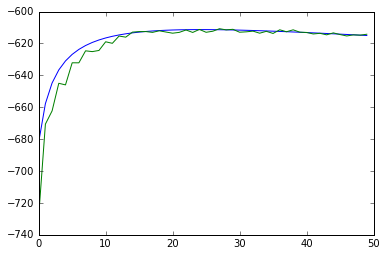

In [20]:
plt.plot(likelihoodxxx)
plt.plot(loglikelihood_withresampling)